In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from eli5.sklearn import InvertableHashingVectorizer
from sklearn.decomposition import PCA

import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

%matplotlib inline

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_train = pd.read_csv('../datasets/df_train_cleaned_shortened.csv')
df_train = df_train.sample(n=8000)

In [3]:
drugName = df_train['drugName'].tolist()
condition = df_train['condition'].tolist()
rating = df_train['rating'].tolist()
reviews = df_train['review'].tolist()

In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in reviews:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 492830 items in vocab_frame


In [8]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, max_features=1000,
                                 min_df=4, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(reviews) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

/Users/ytz/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 9.16 s, sys: 38.8 ms, total: 9.2 s
Wall time: 9.27 s
(8000, 1000)


In [9]:
terms = tfidf_vectorizer.get_feature_names()

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## K-Means

In [11]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 3.62 s, sys: 55.1 ms, total: 3.67 s
Wall time: 1.07 s


In [12]:
import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [13]:
drugs = {'drugName': drugName, 
         'condition': condition, 
         'cluster': clusters, 
         'rating':rating,
        'reviews':reviews}

In [14]:
frame = pd.DataFrame(drugs, index = [clusters] , columns = ['drugName', 'condition', 'reviews','cluster', 'rating'])

In [15]:
frame['cluster'].value_counts()

4    2973
1    2216
2    1374
3     788
0     649
Name: cluster, dtype: int64

In [16]:

grouped = frame['rating'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    7.599384
1    6.767599
2    6.270015
3    6.873096
4    7.345779
Name: rating, dtype: float64

In [17]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for condition in frame.loc[i]['condition'].values.tolist():
        print(' %s,' % condition, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'weight', b'lb', b'lost', b'eat', b'gained', b'pound',

Cluster 0 titles: Obesity, Bipolar Disorde, Weight Loss, Prostate Cance, Obesity, Depression, Obesity, Obesity, Weight Loss, Diabetes, Type 2, Obesity, Weight Loss, Obesity, Obesity, Obesity, Obesity, Weight Loss, Birth Control, Obesity, Anorexia, Weight Loss, Birth Control, Obesity, Obesity, Depression, Anxiety and Stress, Obesity, Bipolar Disorde, Weight Loss, Seizures, Edema, Bipolar Disorde, Diabetes, Type 2, Obesity, Diabetes, Type 2, Weight Loss, Weight Loss, Obesity, Seizures, Major Depressive Disorde, Obesity, Obesity, Obesity, Major Depressive Disorde, Weight Loss, Weight Loss, Birth Control, Obesity, Obesity, Migraine Prevention, Obesity, Bipolar Disorde, Weight Loss, Emergency Contraception, Diabetes, Type 2, Obesity, Obesity, Birth Control, Constipation, Weight Loss, Obesity, Birth Control, Weight Loss, Weight Loss, Obesity, Bipolar Disorde, ADHD, Birth Control, Diabetes, Type 

Cluster 1 titles: Depression, Emergency Contraception, Anxiety, Anxiety, Constipation, Chronic, Constipation, Bipolar Disorde, Cough, Anxiety, Panic Disorde, Birth Control, Generalized Anxiety Disorde, Anxiety, Depression, Dental Abscess, Alcohol Dependence, Depression, Depression, Bipolar Disorde, Anxiety, ADHD, Sinusitis, Shift Work Sleep Disorde, Bipolar Disorde, Insomnia, Depression, Depression, ADHD, GERD, Bowel Preparation, Depression, Paranoid Disorde, Birth Control, Pain, Depression, Major Depressive Disorde, Bowel Preparation, Insomnia, Bacterial Vaginitis, Depression, Diabetes, Type 2, Sjogren's Syndrome, Bipolar Disorde, Nausea/Vomiting, Depression, Muscle Spasm, Anxiety, High Blood Pressure, Dietary Fiber Supplementation, Overactive Bladde, Weight Loss, Myelodysplastic Syndrome, Psoriasis, Urinary Tract Stones, Depression, Bladder Infection, Depression, Meniere's Disease, ADHD, Constipation, Major Depressive Disorde, ADHD, Insomnia, Anxiety, Depression, Emergency Contracept

 Anxiety, Bacterial Infection, Anxiety and Stress, Depression, Depression, Kidney Infections, ADHD, Influenza, Anxiety and Stress, Post Traumatic Stress Disorde, Depression, Bronchitis, Migraine Prevention, Anxiety, Depression, Allergies, Chlamydia Infection, Pain, Postmenopausal Symptoms, Depression, Hepatitis C, Depression, Bipolar Disorde, Psoriatic Arthritis, Rheumatoid Arthritis, Depression, Birth Control, Hashimoto's disease, Asthma, Anxiety, Multiple Sclerosis, Skin or Soft Tissue Infection, Pneumonia, Depression, Chlamydia Infection, Insomnia, ADHD, Depression, Depression, Generalized Anxiety Disorde, Social Anxiety Disorde, Insomnia, Insomnia, Depression, Anxiety, Neuropathic Pain, Anxiety, Anxiety, Obsessive Compulsive Disorde, Supraventricular Tachycardia, Birth Control, Alcohol Dependence, Depression, Oophorectomy, Emergency Contraception, Smoking Cessation, Bowel Preparation, Parkinson's Disease, ADHD, Insomnia, Constipation, High Cholesterol, Pneumonia, Generalized Anxiet

 Major Depressive Disorde, Urinary Tract Infection, Urinary Tract Infection, Narcolepsy, mance Anxiety, Smoking Cessation, Chronic Pain, Major Depressive Disorde, Opiate Dependence, Birth Control, Strep Throat, 4</span> users found this comment helpful., Depression, Depression, Depression, Dementia, Insomnia, Primary Nocturnal Enuresis, Anxiety, Panic Disorde, Anxiety, Anxiety, Not Listed / Othe, Anxiety, ADHD, Sinusitis, Insomnia, Kidney Infections, Smoking Cessation, Influenza, Anxiety, Allergies, Birth Control, Insomnia, Migraine, Helicobacter Pylori Infection, Depression, Birth Control, Depression, Anxiety and Stress, Anxiety, Generalized Anxiety Disorde, Depression, Diverticulitis, Opiate Dependence, Insomnia, Pain, Pain, Depression, Bowel Preparation, Panic Disorde, Undifferentiated Connective Tissue Disease, Muscle Spasm, Emergency Contraception, Cough, Erectile Dysfunction, ADHD, Undifferentiated Connective Tissue Disease, Rheumatoid Arthritis, Anxiety, Bladder Infection, Depre

Cluster 2 titles: Birth Control, Abnormal Uterine Bleeding, Birth Control, Emergency Contraception, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Acne, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Acne, Birth Control, Birth Control, Abnormal Uterine Bleeding, Birth Control, Acne, Polycystic Ovary Syndrome, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, 5</span> users found this comment helpful., Birth Control, Emergency Contraception, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Emergency Contraception, Birth Control, Emergency Contraception, Acne, Birth Control, Birth Control, ibromyalgia, Birth Control, Birth Control, Birth Control, Birth Control, Abnormal Uterine Bleeding, Birth Control, Birth Control, Abnormal Uterine Bleeding, Birth 

 Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Acne, Birth Control, Abnormal Uterine Bleeding, Birth Control, Birth Control, Birth Control, Atrial Fibrillation, Birth Control, Birth Control, Birth Control, Birth Control, Acne, Birth Control, Birth Control, Birth Control, Abnormal Uterine Bleeding, Birth Control, Birth Control, Birth Control, Birth Control, Endometriosis, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Acne, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Birth Control, Abnormal Uterine Bleeding, 0</span> users found this comment helpful., Emergency Contraception, Birth Control, Abnormal Uterine Bleeding, Birth Control, Birth Control, Abnormal Uterine Bleeding, Acne, Birth Control, Acne, Birth Con

Cluster 3 titles: Pain, Pain, Pain, Birth Control, Peripheral Neuropathy, ibromyalgia, Pain, Ankylosing Spondylitis, Birth Control, Neuropathic Pain, Chronic Pain, Pain, Pain, Inflammatory Conditions, Constipation, Chronic Pain, Osteoarthritis, Multiple Sclerosis, Pain, Inflammatory Conditions, Pain, Osteoporosis, Constipation, Pain, Pain, Stomach Ulce, Bipolar Disorde, Bipolar Disorde, Endometriosis, Noninfectious Colitis, Birth Control, Rheumatoid Arthritis, Pain, ibromyalgia, Irritable Bowel Syndrome, Back Pain, Cervical Dystonia, ADHD, Pain, Pain, Major Depressive Disorde, Pain, Chronic Pain, Pain, Weight Loss, Pain, Narcolepsy, Pain, ibromyalgia, Psoriasis, Cluster Headaches, Neuralgia, Pain, Osteoarthritis, Pain, Back Pain, Pulmonary Embolism, Osteoarthritis, Strep Throat, Pain, Urinary Tract Infection, Muscle Spasm, Pain, Pain, Conjunctivitis, Bacterial, Trigeminal Neuralgia, Rheumatoid Arthritis, Irritable Bowel Syndrome, Osteoarthritis, Muscle Spasm, Pain, Pain, Inflammatory C

Cluster 4 words: b'worked', b'use', b'effect', b'ha', b'year', b'helping',



Cluster 4 titles: Acne, Depression, Migraine, Pain, Acne, Panic Disorde, Ulcerative Colitis, Active, Smoking Cessation, Opiate Dependence, Arrhythmia, Bowel Preparation, Vaginal Yeast Infection, Pain, Deep Vein Thrombosis, Major Depressive Disorde, Anesthesia, Opiate Withdrawal, Acne, High Blood Pressure, Acne, Postmenopausal Symptoms, Acne, Major Depressive Disorde, Depression, ADHD, Vaginal Yeast Infection, Narcolepsy, Glaucoma, Bacterial Vaginitis, Asthma, acute, Acne, Crohn's Disease, Depression, Acne, Sinusitis, Cold Sores, Erectile Dysfunction, Acne, Nasal Congestion, Pruritus, Migraine, Skin or Soft Tissue Infection, ADHD, Vaginal Yeast Infection, Schizophrenia, Benign Prostatic Hyperplasia, Bipolar Disorde, Acne, ADHD, ibromyalgia, Motion Sickness, High Cholesterol, Familial Homozygous, Asthma, Maintenance, Birth Control, Trichomoniasis, Muscle Spasm, Seasonal Allergic Conjunctivitis, Insomnia, Diabetes, Type 2, Narcolepsy, Birth Control, ADHD, Acne, Hereditary Angioedema, Beni

 Depression, Chronic Pain, Acne, Pain, Cough and Nasal Congestion, Rosacea, Insomnia, Birth Control, Birth Control, Multiple Sclerosis, Depression, Skin or Soft Tissue Infection, Birth Control, Bronchiectasis, ADHD, Acne, Pain, High Cholesterol, Acne, Bipolar Disorde, Acne, Nephrotic Syndrome, Bowel Preparation, Pain, Obsessive Compulsive Disorde, 18</span> users found this comment helpful., Muscle Spasm, Pain, Prostate Cance, Acne, Premature Lab, Ovulation Induction, Hepatitis C, Allergic Rhinitis, Acne, Depression, Birth Control, Erectile Dysfunction, Insomnia, Depression, Migraine Prevention, Smoking Cessation, Bowel Preparation, Anxiety, Generalized Anxiety Disorde, Overactive Bladde, Depression, Overactive Bladde, Urticaria, Constipation, Depression, Diabetes, Type 1, Overactive Bladde, Atrophic Vaginitis, Migraine Prevention, Urinary Incontinence, Acne, Birth Control, Smoking Cessation, Sinusitis, Osteoarthritis, Dermatological Disorders, Edema, Conjunctivitis, Allergic, High Cho

 Bipolar Disorde, Hypogonadism, Male, ADHD, Sexual Dysfunction, SSRI Induced, Insomnia, Acne, Atopic Dermatitis, Restless Legs Syndrome, Migraine Prevention, Obesity, Chronic Pain, Benign Prostatic Hyperplasia, ADHD, Sjogren's Syndrome, Pain, Headache, Breast Cance, Dry Eye Disease, Pain, Parkinson's Disease, Constipation, Overactive Bladde, ibromyalgia, Cough, Anxiety and Stress, Cold Sores, Depression, Major Depressive Disorde, Diabetic Peripheral Neuropathy, Pityriasis rubra pilaris, Obesity, ADHD, Sinusitis, Sedation, Restless Legs Syndrome, High Cholesterol, Allergic Rhinitis, Glaucoma, Acne, Smoking Cessation, Acne, ADHD, ADHD, Acne, ibromyalgia, Cough and Nasal Congestion, High Blood Pressure, Bipolar Disorde, Asthma, Neuropathic Pain, Migraine, Birth Control, Urinary Incontinence, Diabetes, Type 2, Anxiety, Muscle Spasm, Insomnia, STD Prophylaxis, Vaginal Yeast Infection, Birth Control, Acne, Constipation, Cluster Headaches, Ulcerative Colitis, GERD, Skin or Soft Tissue Infecti

In [18]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [19]:

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

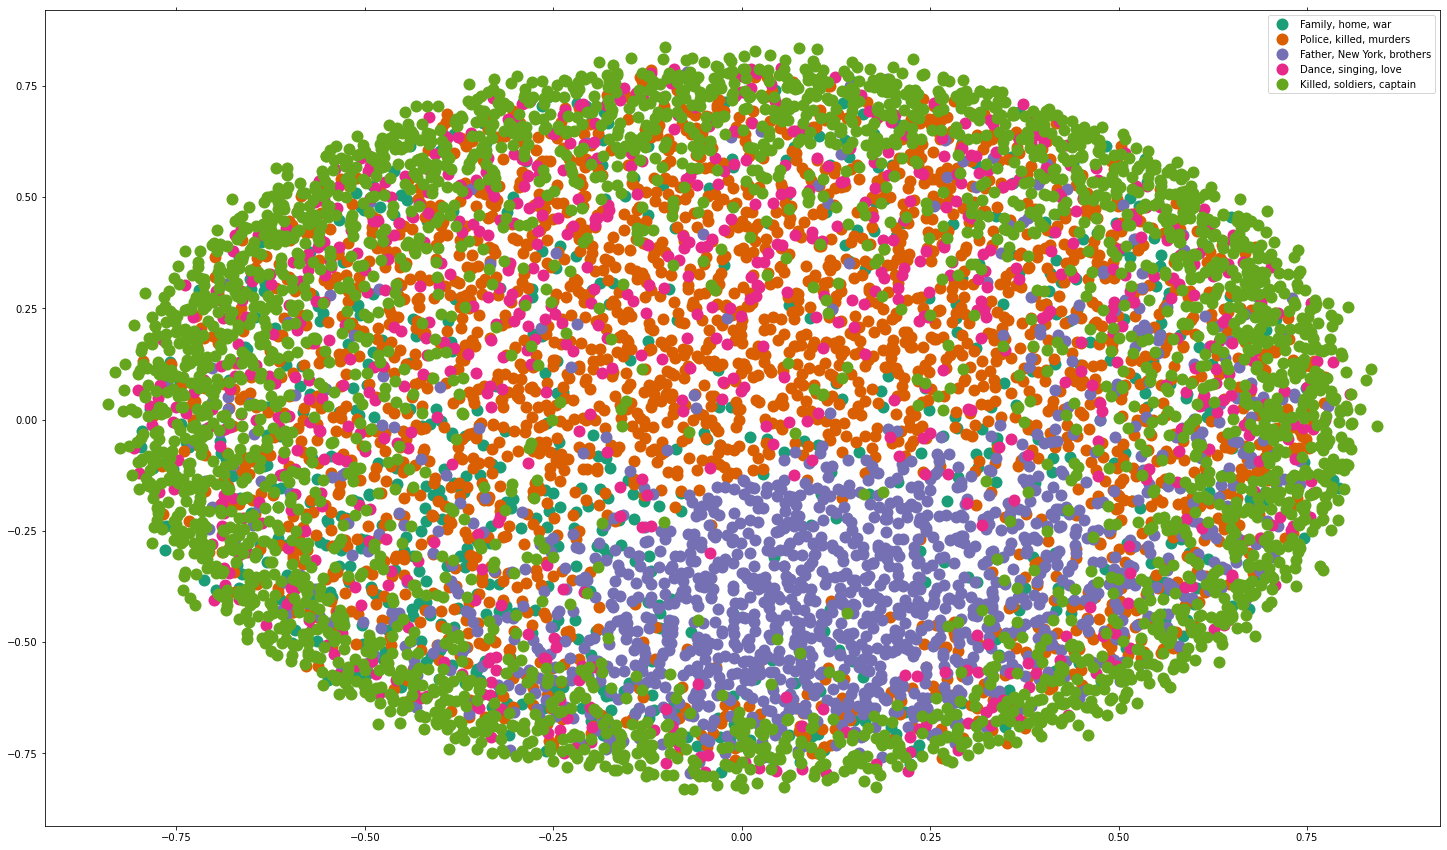

In [24]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=condition)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(25, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
    #ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

In [25]:
plt.close()

## Hierarchical Clustering

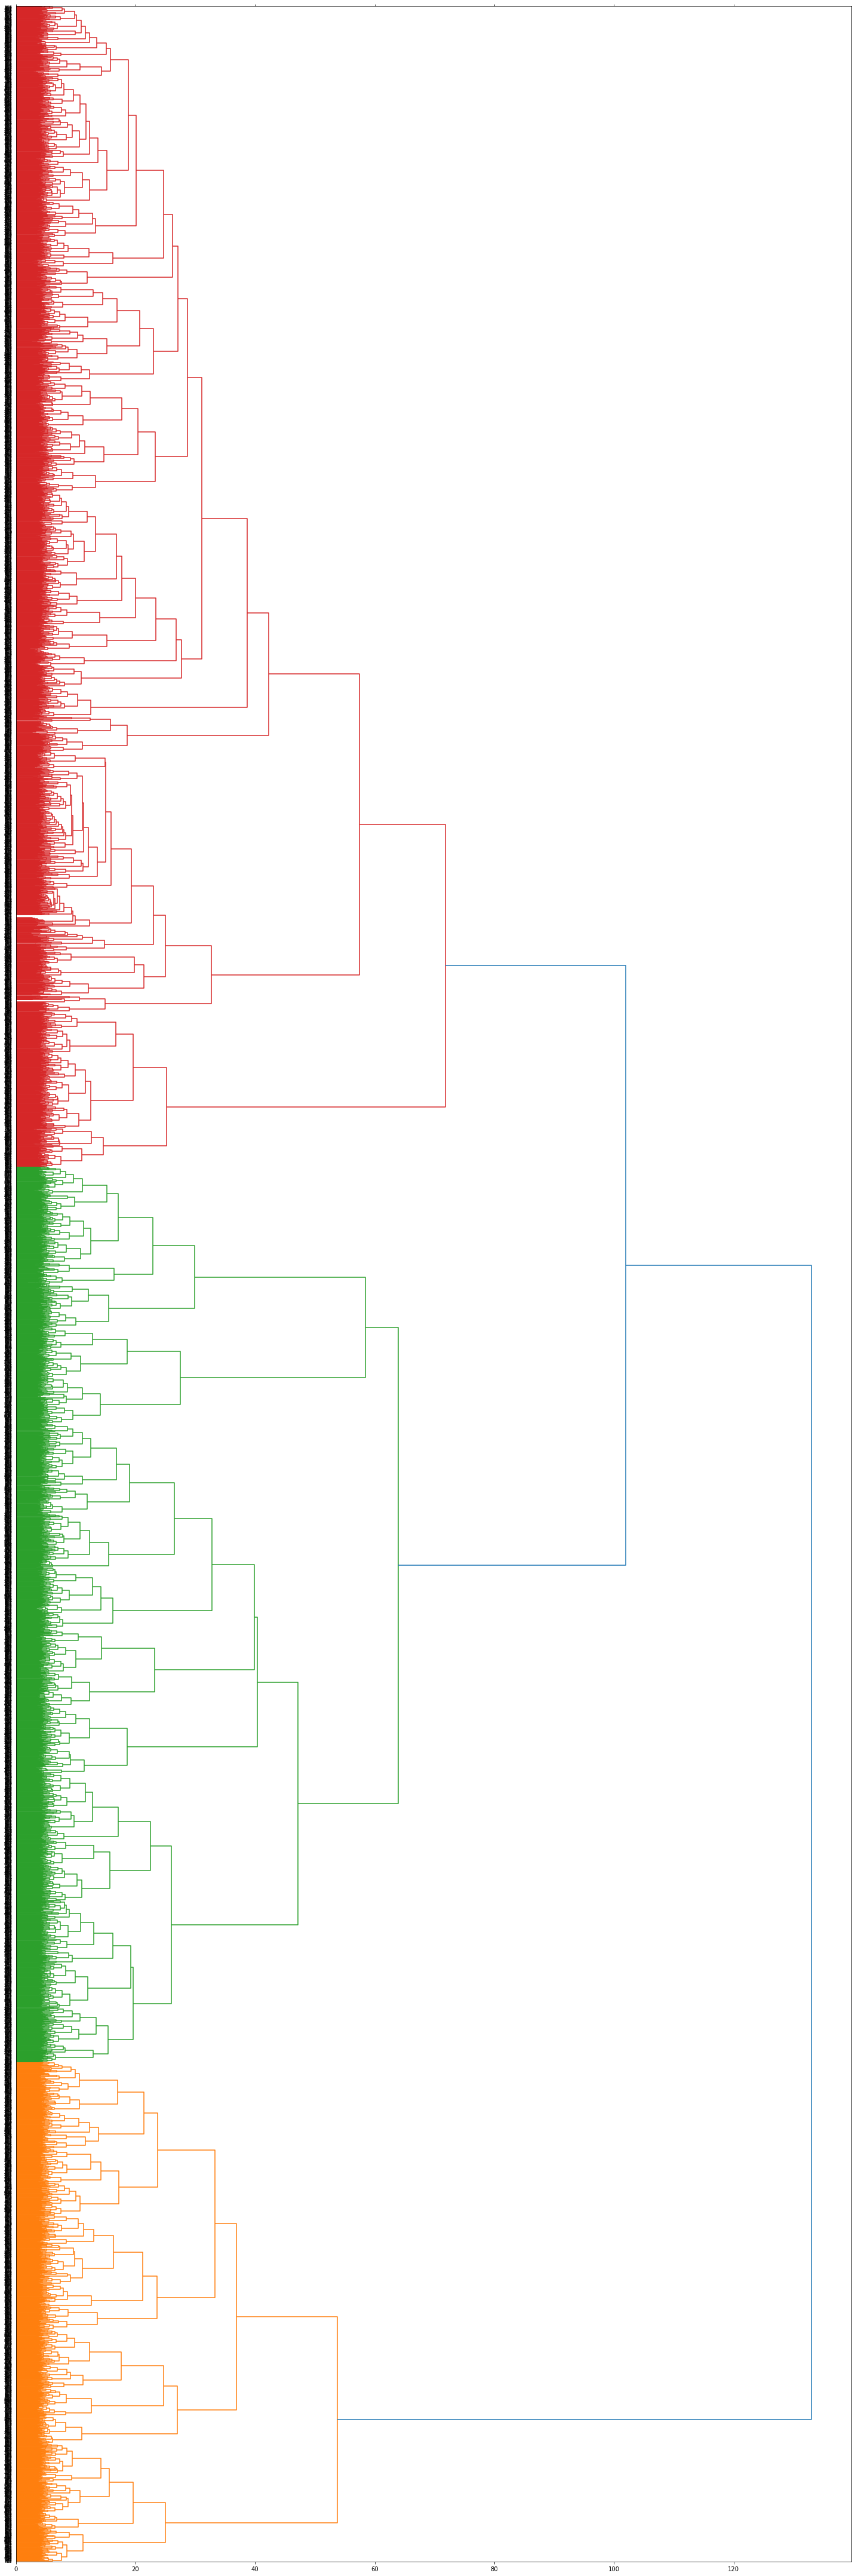

In [30]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20, 60)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
plt.close()